# Testing crowding in star clusters with ellc third light option

### In ellc.lc.__doc__

```
light_3 : float, optional
      Third light contribution relative to total flux from both stars at 
      time t_zero excluding eclipse effects.
```

* Calculate the surface density and number of stars per resolution element
* Created a single star class (that runs through SED, and gives all the magnitudes and fluxes in each filter)
* Draw and evolve some number of singles stars with COSMIC 
* Draw randomly from this set up to the number of stars per resolution element and sum the fluxes
* Use this to define the third light

### To do
* Add the surface density (and crowding fraction?) to the header of the output file
* Add the third light fraction to each line of the output file
* Decide if I should use the fraction of stars per resolution element to define light_3, or should I draw a random number to see if at least 1 star is actually in the same resolution element.  (I think I should use the fraction, but I shold consult with Adam)

In [1]:
import ellc

import numpy as np
import pandas as pd
from astropy import units, constants
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

import sys
sys.path.insert(0, '/Users/ageller/WORK/LSST/onGitHub/EBLSST/code')
from LSSTEBClusterWorker import LSSTEBClusterWorker
from OpSim import OpSim
from getClusterBinaries import getClusterBinaries
from SED import SED

%load_ext autoreload
%autoreload 2

/Users/ageller/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/ageller/python_scripts/PySynphotData/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/Users/ageller/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/ageller/python_scripts/PySynphotData/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))


### First, let's test the light_3 option in ellc

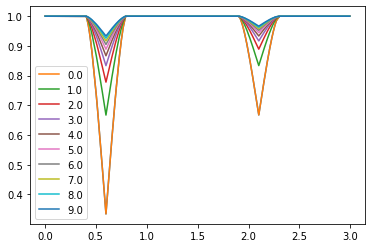

In [2]:
period = 3 #days
r1 = 0.2 #solar radii
r2 = 0.2 #solar radii
sbratio = 0.5
incl = 90. #degrees
t_zero = 0.2*period
t_obs = np.sort(np.random.random(500)*1.*period)

lc_clean = ellc.lc(t_obs, period=period, radius_1=r1, radius_2=r2, sbratio=sbratio, 
                   incl=incl, t_zero=t_zero)

f,ax = plt.subplots()
ax.plot(t_obs, lc_clean)

third = np.linspace(0,9, 10)
for t in third:
    lc_third = ellc.lc(t_obs, period=period, radius_1=r1, radius_2=r2, sbratio=sbratio, 
                       incl=incl, t_zero=t_zero, light_3 = t)
    ax.plot(t_obs, lc_third, label=t)

ax.legend()

### Now let's try converting a surface density to a number of stars in the LSST resolution element

pixel size : 0.2 arcsec (https://www.lsst.org/scientists/keynumbers)

median seeing: 0.7 arsec (https://en.wikipedia.org/wiki/Large_Synoptic_Survey_Telescope)

I will assume that one resolution element is (2.*0.7)^2 

*Should I simply use the stars per resolution element to define the light_3, or should I draw a random number and see if a star would actually fall in the same resolution element?  I think I will use the fraction.*

In [3]:
seeing = 0.7 #arcsec
resEl = (2.*seeing/60.)**2. #arcmin^2

In [4]:
#lets use M10 as an example to test
GCDF = pd.read_csv("/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/clusters/GCdataForEBLSST.csv").fillna(0.)
OCDF = pd.read_csv("/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/clusters/OCdataForEBLSST.csv").fillna(0.)
GCDF

,ID,RA[hr],Dec[deg],dist[pc],rhm[pc],mass[Msun],age[Myr],[Fe/H],sigma_v0_z[km/s],OpSimID,OpSimRA[deg],OpSimDec[deg]
0,NGC 104,00 24 05.67,-72 04 52.6,4500.0,4.149521,1.059327e+06,12343.750000,-0.720000,11.000000,114.0,5.606889,-73.293784
1,NGC 288,00 52 45.24,-26 34 57.4,8900.0,5.773259,9.057952e+04,9757.440476,-1.320000,2.900000,1524.0,14.033108,-25.294617
2,NGC 362,01 03 14.26,-70 50 55.6,8600.0,2.051344,4.256278e+05,9522.321429,-1.260000,6.400000,162.0,19.216740,-70.227766
3,Whiting 1,02 02 57,-03 15 10,30100.0,1.926262,1.741927e+03,11081.821987,-0.700000,0.864470,2508.0,29.637645,-2.836499
4,NGC 1261,03 12 16.21,-55 12 58.4,16300.0,3.224205,2.382484e+05,9287.202381,-1.270000,7.814409,492.0,50.475658,-54.543202
5,Pal 1,03 33 20.04,+79 34 51.8,11100.0,1.485275,1.840899e+03,6465.773810,-0.650000,1.012055,5250.0,55.141667,80.199608
6,AM 1,03 55 02.3,-49 36 55,123300.0,14.705272,1.409386e+04,11081.821987,-1.700000,0.889961,621.0,57.903841,-50.212216
7,Eridanus,04 24 44.5,-21 11 13,90100.0,12.056153,2.037183e+04,11081.821987,-1.430000,1.181689,1714.0,67.408736,-20.535329
8,Pal 2,04 46 05.91,+31 22 53.4,27200.0,3.956080,2.786314e+05,11081.821987,-1.420000,7.629128,4053.0,72.000010,31.829949
9,NGC 1851,05 14 06.76,-40 02 47.6,12100.0,1.795071,3.881772e+05,8816.964286,-1.180000,10.400000,949.0,79.406498,-39.869134


In [5]:
field = GCDF.loc[GCDF['ID'] == 'NGC 6254'] #M10 GC
#field = OCDF.loc[OCDF['ID'] ==  'NGC_2682'] #M67 OC

In [6]:
def getStarsPerResEl(rh, mass, dist, d2D=None):
    #from a Plummer model
    #pick a radius randomly from the Plummer model
    #From Kroupa's initial conditions (eq. 8.102)
    rPlummer = rh*(2**(2./3.) - 1.)**0.5

    if (d2D == None):
        print('drawing a random projected distance from the center')
        X1 = np.random.random()
        X2 = np.random.random()
        X3 = np.random.random()
        zeta = (X1**(-2/3.) - 1.)**(-0.5)
        r = zeta*rPlummer
        #this is a 3D r; we need to make this 2D
        z = 2.*r*X2 - r
        x = (r**2. - z**2.)**0.5*np.cos(X3*2.*np.pi)
        y = (r**2. - z**2.)**0.5*np.sin(X3*2.*np.pi)
        d2D = (x**2. + y**2.)**0.5
    
    #projected mass density
    massDensity = mass/(np.pi*rPlummer**2.)*(1. + d2D**2./rPlummer**2.)**-2. #Msun/pc**2.

    #take some mean stellar mass to convert to stars/pc**2
    meanMass = 0.5
    numberDensity = massDensity/meanMass

    #convert the denominator to arcmin^2
    angle = np.arctan2(1., dist)*180./np.pi*60. #arcmin/pc
    surfaceDensity = numberDensity/angle**2.

    #stars/resolution element
    starsPerResEl = surfaceDensity*resEl

    #print(f' r = {r} pc \n dist = {dist} kpc \n angle = {angle} arcmin \n MSigmapc = {massDensity} Msun/pc^2 \n NSigmapc = {numberDensity} stars/pc^2 \n NSigma = {surfaceDensity} stars/arcmin^2 \n N/res = {starsPerResEl} stars/resolution element')
    return starsPerResEl, d2D

rh = field['rhm[pc]'].values[0]
mass = field['mass[Msun]'].values[0]
dist = field['dist[pc]'].values[0]
starsPerResEl, d = getStarsPerResEl(rh, mass, dist, d2D=0)
print(f' d = {d} pc \n N/res = {starsPerResEl} stars/resolution element')

 d = 0 pc 
 N/res = 27.533388853176206 stars/resolution element


### Test the single evolution bits in getClusterBinaries

In [7]:
sampler = getClusterBinaries(field['age[Myr]'].values[0], 
                             field['[Fe/H]'].values[0], 
                             field['sigma_v0_z[km/s]'].values[0], 
                             100)
sampler.random_seed = 1111.
sampler.dist = dist/1000.
sampler.Nsing = 100
sampler.Initial_Single_Sample()

initial single input: 1111.0 10345.238095238095 -1.56 100


In [8]:
sampler.EvolveSingles()
sampler.SinglesEvolved

KeyError: 'ecsn'

## Single star class to get Fluxes

In [ ]:
from dust_extinction.parameter_averages import F04
import numpy as np

#for A_V
#import vespa.stars.extinction
from vespa_update import extinction

#class to get the SED values for singles
class SingleStar(object):
    def __init__(self, *args,**kwargs):
        
        self.SED = None
        self.m = None #*units.solMass
        self.R = None #*units.solRad
        self.L = None #*units.solLum
        self.M_H = 0. #metallicity
        self.AV = None
        self.RA = None
        self.Dec = None
        self.dist = None #*units.kpc
        
        #these will be calculated
        self.T = None #Kelvin
        self.logg = None 
        self.Fv = dict()
        self.Ared = dict()
        self.BC = dict()
        self.appMagMean = dict()

        #don't touch these
        self.filters = ['u_', 'g_', 'r_', 'i_', 'z_', 'y_']
        self.filterFilesRoot = '/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/filters/'
        self.RV = 3.1
        #from https://www.lsst.org/scientists/keynumbers
        #in nm
        self.wavelength = {
            'u_': (324. + 395.)/2.,
            'g_': (405. + 552.)/2.,
            'r_': (552. + 691.)/2.,
            'i_': (691. + 818.)/2.,
            'z_': (818. + 921.)/2.,
            'y_': (922. + 997. )/2.
        } 
        
    #also in EclipsingBinary
    def getTeff(self, L, R):
        #use stellar radius and stellar luminosity to get the star's effective temperature
        logTeff = 3.762 + 0.25*np.log10(L) - 0.5*np.log10(R) 
        return 10.**logTeff

    def getlogg(self,m, L, T):
        #use stellar mass, luminosity, and effective temperature to get log(gravity)
        return np.log10(m) + 4.*np.log10(T) - np.log10(L) - 10.6071
    
    def initialize(self):
        if (self.T == None): self.T = self.getTeff(self.L, self.r)
        if (self.logg == None): self.logg = self.getlogg(self.m, self.L, self.T)  
        #one option for getting the extinction
        if (self.AV == None):
            count = 0
            while (self.AV == None and count < 100):
                self.AV = extinction.get_AV_infinity(self.RA, self.Dec, frame='icrs')
                if (self.AV == None):
                    print("WARNING: No AV found", self.RA, self.Dec, self.AV, count)
                    
        #initialize the SED
        self.SED = SED()
        self.SED.filters = self.filters
        self.SED.filterFilesRoot = self.filterFilesRoot
        self.SED.T = self.T*units.K
        self.SED.R = self.R*units.solRad
        self.SED.L = self.L*units.solLum
        self.SED.logg = self.logg
        self.SED.M_H = self.M_H
        self.SED.EBV = self.AV/self.RV #could use this to account for reddening in SED
        self.SED.initialize()
        
        #one option for getting the extinction
        ext = F04(Rv=self.RV)
        Lconst = self.SED.getLconst()
        for f in self.filters:
            self.Ared[f] = ext(self.wavelength[f]*units.nm)*self.AV
            self.Fv[f] = self.SED.getFvAB(self.dist*units.kpc, f, Lconst = Lconst)
            self.appMagMean[f] = -2.5*np.log10(self.Fv[f]) + self.Ared[f] #AB magnitude 


### Use this class to get the combined mag for the third light

*Could add this into the getClusterBinaries class*

In [ ]:
#Sum up the flux from Nsingles random stars drawn from the evolved single population
#I will use the ceiling of starsPerResEl, then cut it back to the fractional value
def getThirdLight(starsPerResEl, sampler, AV):
    Nsingles = int(np.ceil(starsPerResEl))
    singlesFv = dict()
    filters = ['u_', 'g_', 'r_', 'i_', 'z_', 'y_']       
                    
    for i in range(Nsingles):
        #sample a random star
        star = sampler.SinglesEvolved.sample()
        s = SingleStar()
        s.M_H = field['[Fe/H]'].values[0]

        s.RA = coord.ra.to(units.degree).value
        s.Dec = coord.dec.to(units.degree).value
        s.dist = field['dist[pc]'].values[0]/1000.
        s.AV = AV
        
        s.m = star['mass_1'].values[0]
        s.R = 10.**star['rad_1'].values[0]
        s.L = 10.**star['lumin_1'].values[0]
        s.T = 10.**star['teff_1'].values[0]
        s.initialize()
        #print(s.m, s.Fv, s.appMagMean)
        
        for f in filters:
            if (i == 0):
                singlesFv[f] = s.Fv[f]
            else:
                singlesFv[f] += s.Fv[f]
                
    #check the combined magnitude
    appMagMean = dict()
    frac = starsPerResEl/Nsingles
    #print(frac)
    for f in filters:
        #trim off the extra flux to match the starsPerResEl? <-- THIS NEEDS IMPROVEMENT
        singlesFv[f] *= frac
        appMagMean[f] = -2.5*np.log10(singlesFv[f]) + s.Ared[f] #AB magnitude 
    
    return singlesFv, appMagMean

In [ ]:
coord = SkyCoord(field['RA[hr]'].values[0], field['RA[hr]'].values[0], 
            unit=[units.hourangle, units.degree])
AV = extinction.get_AV_infinity(coord.ra, coord.dec, frame='icrs')
        
singlesFv, appMagMean = getThirdLight(starsPerResEl, sampler, AV)

print('Nsingles = ', int(np.ceil(starsPerResEl)))
print('total flux = ',singlesFv )
print('combined mag = ',appMagMean )

## Running as if I'm using the MPI driver code

In [ ]:
OpS = OpSim()
OpS.dbFile = '/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/db/baseline2018a.db'
OpS.getCursors()

In [ ]:
OpS.fieldID = field['OpSimID'].values
OpS.RA = field['OpSimRA[deg]'].values
OpS.Dec = field['OpSimDec[deg]'].values
OpS.obsDates = np.full_like(OpS.fieldID, dict(), dtype=dict)
OpS.NobsDates = np.full_like(OpS.fieldID, dict(), dtype=dict)
OpS.m_5 = np.full_like(OpS.fieldID, dict(), dtype=dict)
OpS.totalNobs = np.full_like(OpS.fieldID, 0)

In [ ]:
OpSimi = 0
worker = LSSTEBClusterWorker()
worker.filterFilesRoot = '/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/filters/'
worker.clusterName = field['ID'].values
worker.clusterMass = field['mass[Msun]'].values
worker.clusterDistance = field['dist[pc]'].values/1000.
worker.clusterMetallicity = field['[Fe/H]'].values
worker.clusterAge = field['age[Myr[]]'].values
worker.clusterRhm = field['rhm[pc]'].values
worker.clusterVdisp = field['sigma_v0_z[km/s]'].values
    
worker.OpSim = OpS

worker.seed = 1111

worker.initialize(OpSimi)

In [ ]:
worker.n_bin = 100
clusterDat = worker.sampleCluster(OpSimi)

In [ ]:
i=7
line= clusterDat[i]
#change the inclination
line[12] = np.pi/2.
#change the period
line[2] = np.log10(3.47)

EB = worker.getEB(line, OpSimi=OpSimi)

rh = field['rhm[pc]'].values[0]
mass = field['mass[Msun]'].values[0]
dist = field['dist[pc]'].values[0]/1000.
d2D = np.linspace(0,10, 9)
singlesFvArr = []
for d in d2D:
    starsPerResEl, dd = getStarsPerResEl(rh, mass, dist, d2D = d)
    sFv, _ = getThirdLight(starsPerResEl, sampler)
    singlesFvArr.append(sFv)
    print(d, dd,starsPerResEl, sFv)

print(EB.period, EB.inclination, EB.R_1, EB.R_2, EB.sbratio, EB.q)

In [ ]:
cmap = matplotlib.cm.get_cmap('tab10')

fig,ax = plt.subplots(6,1, figsize=(10,30), sharex = True)
for i,f in enumerate(worker.filters):

    #default
    EB.light_3 = 0.
    EB.observe(f)
    phase = (EB.obsDates[f] % EB.period)
    sort = np.argsort(phase)
    ax[i].plot(phase[sort], EB.appMag[f][sort], color='green')
    ax[i].set_ylim(max(EB.appMagObs[f]), min(EB.appMagObs[f]))
    ax[i].set_ylabel(f)
    ax[i].set_xlim(min(phase), max(phase))
    
    #with crowding
    for j,s in enumerate(singlesFvArr):
        EB.light_3 = s[f]/(EB.Fv1[f] + EB.Fv2[f])
        EB.observe(f)
        ax[i].plot(phase[sort], EB.appMag[f][sort], color=cmap(float(j)/len(d2D)), label=d2D[j], linewidth=2)
        ax[i].plot(phase[sort], EB.appMagObs[f][sort], '.', alpha=0.3, color=cmap(float(j)/len(d2D)))
        print(i,j, d2D[j], f, EB.light_3)

plt.subplots_adjust(hspace=0)
ax[0].legend(bbox_to_anchor=(1.2,1))